<a href="https://colab.research.google.com/github/maxmatical/Machine-Learning/blob/master/Gold_Case_Study_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Required Packages

In [1]:
# Set up environment and download course-v3
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai
!pip install fastprogress
!pip install pathlib

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.6MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6281a000 @  0x7f6c59d642a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 133kB 3.6MB/s 
    100% |████████████████████████████████| 163kB 8.1MB/s 
    100% |████████████████████████████████| 112kB 30.1MB/s 
    100% |████████████████████████████████| 61kB 23.1MB/s 
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e4
Successfully built bottleneck
torchvision-nightly 0.2.1 has requirement pillow>=4.1.1

In [0]:
 !curl https://course-v3.fast.ai/setup/colab | bash

In [0]:
from fastai import *
from fastai.tabular import *


In [0]:

import pandas as pd
import matplotlib as plt
import numpy as np

In [5]:
# check the directory of the data 
!ls -d $PWD/*

/content/course-v3  /content/data  /content/models


# Loading in Data

using a function to concatenate csvs 

In [0]:
path = '/content/data/'
os.makedirs(path, exist_ok=True)
#path


In [7]:
!ls {path}

 C1_Comdty_t.csv   chicago_weather_t.csv  'GC1 Comdty_t.csv'   us_macro_t.csv


In [8]:
# check the directory of the data 
!ls -d $PWD/*

/content/course-v3  /content/data  /content/models


In [0]:
table_names = ['C1_Comdty_t', 'GC1 Comdty_t', 'chicago_weather_t', 'us_macro_t']

In [0]:
tables = [pd.read_csv(f'{path}{fname}.csv', low_memory=False) for fname in table_names]


Naming tables

In [0]:
C1 = tables[0]
GC1 = tables[1]
chicago_weather = tables[2]
us_macro = tables[3]


# Exploratory Data Analysis

In [0]:
from IPython.display import HTML, display


In [0]:
! pip install pandas-summary
from pandas_summary import DataFrameSummary


In [0]:
# looking at all data
for t in tables: display(t.head())

In [0]:
# looking at summarized data
for t in tables: display(t.describe(include='all'))

# Data Cleaning and Feature Engineering

creating Month field for all tables

In [0]:
GC1['Month'] = pd.DatetimeIndex(GC1['GC1 Comdty']).month
C1['Month'] = pd.DatetimeIndex(C1['C 1 Comdty']).month
chicago_weather['Month'] = pd.DatetimeIndex(chicago_weather['DATE']).month
us_macro['Month'] = pd.DatetimeIndex(us_macro['date']).month

creating year field for year to join chicago_weather and us_macro

In [0]:
# us_macro['Year'] =  pd.DatetimeIndex(us_macro['date']).year
# chicago_weather['Year'] = pd.DatetimeIndex(chicago_weather['DATE']).year

chicago_weather['Month_Year'] = pd.to_datetime(chicago_weather['DATE']).dt.to_period('M')
us_macro['Month_Year'] = pd.to_datetime(us_macro['date']).dt.to_period('M')


Join function to join pandas dataframes

We don't use an inner join because we won't want to delete any values (yet), we just want them to appear as null, so we can analyze them later

In [0]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [0]:
# joining corn and gold based on date
gold = join_df(GC1,C1, 'GC1 Comdty', 'C 1 Comdty', suffix = '_corn')


In [0]:
#gold

In [0]:
# joining chicago weather and us macro
us_stats = join_df(chicago_weather, us_macro, 'Month_Year', 'Month_Year', suffix = '_us')

In [0]:
#us_stats

Finally, combine the 2 tables together

In [0]:
concat_data = join_df(gold, us_stats, 'GC1 Comdty', 'DATE', suffix = '_y')

In [0]:
#concat_data

In [0]:
# saving data
#concat_data.to_csv('concat_data.csv')

Next, we want to drop all duplicate/useless information

In [0]:
concat_clean = concat_data.drop(['Unnamed: 0', 'Bid', 'Ask', 'Unnamed: 0_corn', 'Unnamed: 0.1',
                 'C 1 Comdty', 'Bid_corn', 'Ask_corn', 'Month_corn', 'Unnamed: 0_y', 'LATITUDE', 'LONGITUDE',
                 'ELEVATION', 'DATE', 'Month_y', 'Month_Year', 'Unnamed: 0_us', 'date', 'Month_us'], axis=1)

In [0]:
concat_clean = concat_clean.rename(columns={'GC1 Comdty': 'Date', 'Last':'Price'})

Optional: remove any instances where there is no price for gold

In [0]:
#concat_clean.dropna(subset=['Price'])

#concat_clean = concat_clean.dropna(subset=['Price'])

In [0]:
concat_clean.head()

,Date,Price,High,Low,Volume,Open_Interest,Month,Year,Last_corn,High_corn,Low_corn,Volume_corn,Open_Interest_corn,TAVG,gdp,cpi,int,nettrade
0,1/6/2000,282.4,282.8,280.2,26026.0,67505.0,1,2000,203.75,205.75,203.00,37490.0,216368.0,30.0,NaN,NaN,NaN,NaN
1,1/7/2000,282.9,284.5,282.0,19396.0,68731.0,1,2000,NaN,NaN,202.50,46637.0,219250.0,24.0,NaN,NaN,NaN,NaN
2,1/10/2000,282.7,283.9,281.8,11612.0,66778.0,1,2000,208.50,209.25,204.75,47788.0,218442.0,40.0,NaN,NaN,NaN,NaN
3,1/11/2000,284.4,285.3,281.9,30928.0,64731.0,1,2000,207.25,209.25,206.25,41233.0,218977.0,NaN,NaN,NaN,NaN,NaN
4,1/12/2000,283.7,285.0,282.5,13678.0,64629.0,1,2000,215.50,216.75,206.75,122388.0,229517.0,29.0,NaN,NaN,NaN,NaN


Save cleaned csv

In [0]:
concat_clean.to_csv('concat_clean.csv')

## Dealing with NaNs

Possible Strategies
- replace NA with a value not seen in the dataset
- replace NA with an avg/median value `df.fillna(df.mean(), inplace=True`)
- replace NA with last seen value `df.fillna(method='ffill', inplace=True)`

We try using last strategy (fill in with last seen value)

First we want to fill in the 1st row for us_macro stats

In [0]:
concat_clean['gdp'][0] = 9697.2
concat_clean['cpi'][0] = 0.870492853
concat_clean['int'][0] = 5.73
concat_clean['nettrade'][0] = -29930

In [0]:
#concat_clean = concat_clean.fillna(concat_clean.mean.astype(np.int32))

concat_clean.fillna(method='ffill', inplace=True)

In [0]:
#concat_clean.head()

saving data

In [0]:
concat_clean.to_csv('concat_clean_fillna.csv')

In [21]:
len(concat_clean)

1396

after cleaning the data, we are left with 1396 observations of 17 features

## Engineering New Features

changing price to float32

In [0]:
concat_clean['Price'] = concat_clean['Price'].astype('float32')

Creating day of week feature

In [0]:
concat_clean['Date-Time'] = pd.to_datetime(concat_clean['Date'])


In [0]:
concat_clean['Weekday'] = concat_clean['Date-Time'].dt.dayofweek

In [0]:
# deleting date-time
concat_clean = concat_clean.drop(['Date-Time'], axis = 1)

In [31]:
concat_clean.head()

,Date,Price,High,Low,Volume,Open_Interest,Month,Last_corn,High_corn,Low_corn,Volume_corn,Open_Interest_corn,TAVG,gdp,cpi,int,nettrade,Weekday
0,1/6/2000,282.399994,282.8,280.2,26026.0,67505.0,1,203.75,205.75,203.00,37490.0,216368.0,30.0,9697.2,0.870493,5.73,-29930.0,3
1,1/7/2000,282.899994,284.5,282.0,19396.0,68731.0,1,203.75,205.75,202.50,46637.0,219250.0,24.0,9697.2,0.870493,5.73,-29930.0,4
2,1/10/2000,282.700012,283.9,281.8,11612.0,66778.0,1,208.50,209.25,204.75,47788.0,218442.0,40.0,9697.2,0.870493,5.73,-29930.0,0
3,1/11/2000,284.399994,285.3,281.9,30928.0,64731.0,1,207.25,209.25,206.25,41233.0,218977.0,40.0,9697.2,0.870493,5.73,-29930.0,1
4,1/12/2000,283.700012,285.0,282.5,13678.0,64629.0,1,215.50,216.75,206.75,122388.0,229517.0,29.0,9697.2,0.870493,5.73,-29930.0,2


(OPTIONAL)add Year+Month as feature

In [0]:
#concat_clean['Month_Year'] = pd.to_datetime(concat_clean['Date']).dt.to_period('M')

In [32]:
concat_clean.describe(include='all')


,Date,Price,High,Low,Volume,Open_Interest,Month,Last_corn,High_corn,Low_corn,Volume_corn,Open_Interest_corn,TAVG,gdp,cpi,int,nettrade,Weekday
count,1396,1396.000000,1396.000000,1396.000000,1396.00000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000
unique,1396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,3/24/2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,337.893188,339.867622,335.943481,17583.46490,48992.016476,6.274355,224.952364,227.177113,222.804979,32740.053009,150963.580946,49.231375,10839.078510,0.930911,2.844427,-39704.636103,2.017908
std,NaN,60.512489,60.925923,59.887781,23267.96006,62312.826674,3.386027,28.609813,29.061847,27.950594,20566.028123,104003.747021,19.798379,789.261278,0.034888,1.951549,9664.234832,1.399578
min,NaN,255.100006,255.000000,255.000000,1.00000,2.000000,1.000000,174.750000,175.750000,174.000000,3.000000,58.000000,-5.000000,9697.200000,0.870493,0.980000,-58819.000000,0.000000
25%,NaN,279.200012,280.475000,277.700000,115.75000,496.000000,3.000000,206.000000,207.750000,204.750000,18599.250000,55380.250000,34.000000,10221.600000,0.907873,1.260000,-46484.000000,1.000000
50%,NaN,320.899994,322.950000,319.600000,1993.50000,11953.000000,6.000000,218.000000,220.000000,215.500000,31581.500000,157563.500000,51.000000,10572.300000,0.927843,1.760000,-36519.000000,2.000000
75%,NaN,398.025002,401.075000,394.600000,31402.75000,83600.750000,9.000000,237.750000,239.750000,235.500000,43074.750000,225783.500000,66.000000,11447.800000,0.958054,4.210000,-31150.750000,3.000000


Add Year as a feature

In [0]:
concat_clean['Year'] = pd.DatetimeIndex(concat_clean['Date']).year

Deleting Date as a feature

In [0]:
concat_clean = concat_clean.drop(['Date'], axis = 1)

In [35]:
concat_clean.head()

,Price,High,Low,Volume,Open_Interest,Month,Last_corn,High_corn,Low_corn,Volume_corn,Open_Interest_corn,TAVG,gdp,cpi,int,nettrade,Weekday,Year
0,282.399994,282.8,280.2,26026.0,67505.0,1,203.75,205.75,203.00,37490.0,216368.0,30.0,9697.2,0.870493,5.73,-29930.0,3,2000
1,282.899994,284.5,282.0,19396.0,68731.0,1,203.75,205.75,202.50,46637.0,219250.0,24.0,9697.2,0.870493,5.73,-29930.0,4,2000
2,282.700012,283.9,281.8,11612.0,66778.0,1,208.50,209.25,204.75,47788.0,218442.0,40.0,9697.2,0.870493,5.73,-29930.0,0,2000
3,284.399994,285.3,281.9,30928.0,64731.0,1,207.25,209.25,206.25,41233.0,218977.0,40.0,9697.2,0.870493,5.73,-29930.0,1,2000
4,283.700012,285.0,282.5,13678.0,64629.0,1,215.50,216.75,206.75,122388.0,229517.0,29.0,9697.2,0.870493,5.73,-29930.0,2,2000


# Setting up training data

List categorical and continuous variables

In order to use categorical variables, we use entity embedding to find distributed representation of categorical data

For this we use min(50, size(var)//2)

So month => 6, Date =>50, and Month_Year => 3


Because financial data is often heavy-tailed, instead of looking at the price of gold, we can look at the log of the price

Creating Log of price

In [0]:
concat_clean['Log_Price'] = np.log(concat_clean['Price'])

In [0]:
concat_clean['Log_Price'] = concat_clean['Log_Price'].astype('float32')

In [0]:
concat_clean = concat_clean.drop(['Price'], axis = 1)

In [39]:
concat_clean.head()

,High,Low,Volume,Open_Interest,Month,Last_corn,High_corn,Low_corn,Volume_corn,Open_Interest_corn,TAVG,gdp,cpi,int,nettrade,Weekday,Year,Log_Price
0,282.8,280.2,26026.0,67505.0,1,203.75,205.75,203.00,37490.0,216368.0,30.0,9697.2,0.870493,5.73,-29930.0,3,2000,5.643324
1,284.5,282.0,19396.0,68731.0,1,203.75,205.75,202.50,46637.0,219250.0,24.0,9697.2,0.870493,5.73,-29930.0,4,2000,5.645093
2,283.9,281.8,11612.0,66778.0,1,208.50,209.25,204.75,47788.0,218442.0,40.0,9697.2,0.870493,5.73,-29930.0,0,2000,5.644386
3,285.3,281.9,30928.0,64731.0,1,207.25,209.25,206.25,41233.0,218977.0,40.0,9697.2,0.870493,5.73,-29930.0,1,2000,5.650382
4,285.0,282.5,13678.0,64629.0,1,215.50,216.75,206.75,122388.0,229517.0,29.0,9697.2,0.870493,5.73,-29930.0,2,2000,5.647917


In [0]:
cat_vars = ['Year', 'Month', 'Weekday']
cont_vars = ['High', 'Low', 'Volume', 'Open_Interest', 'Last_corn', 'High_corn', 'Low_corn',
            'Volume_corn', 'Open_Interest_corn', 'TAVG', 'gdp', 'cpi', 'int', 'nettrade']
dep_var = 'Log_Price'

In [0]:
concat_clean[dep_var]

## Splitting into Train/Val set

Since we're working with time series data, the rule of thumb is typically to reserve the last 20% of training data for validation

In [0]:
sample_size = len(concat_clean)
train_ratio = 0.8
train_size = int(sample_size * train_ratio); train_size
val_idx = list(range(train_size, len(concat_clean)))

In [44]:
print(train_size)
print(len(val_idx))
print(train_size+len(val_idx))

1116
280
1396


In [0]:
train_df, valid_df = concat_clean[:train_size].copy(),concat_clean[train_size:].copy()

In [0]:
valid_df.head()

# Deep Learning

We can evaluate the performance of the model using Root Mean Square Percentage Error (RMSPE)

This is a good metric to evaluate the performance of the model because we want penalize values that are more off more harshly (i.e. a big difference in predicted and actual price is more harmful to the investor than a small difference)

Because we are using the log(Price) in our data, we need to take exp(RMSPE)

defining variable transformations

In [0]:
tfms = [Categorify, Normalize]

setting up databunch api from fastai

In [0]:
??TabularDataBunch.from_df

In [0]:
??DataBunch

In [0]:
??TabularList

In [0]:
??TabularList.label_from_df

In [0]:
bs = 128

# data = (TabularList.from_df(concat_clean, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=tfms)
#                    .split_by_idx(val_idx)
#                    .label_from_df(cols=dep_var, label_cls=F)
#                    .databunch(bs = bs))

data = (TabularList.from_df(concat_clean, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=tfms)
                   .split_by_idx(val_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch(bs = bs))

In [0]:
learn = tabular_learner(data, layers = [1000,500], emb_drop = 0.05, metrics = [exp_rmspe], ps = [0.5, 0.5])

# learn = tabular_learner(data, layers = [1000,500], emb_szs = {'Year':3, 'Month':6, 'Month_Year':34},
#                            metrics = [exp_rmspe], ps = [0.5, 0.5])

    
# learn = get_tabular_learner(data, layers = [1000,500])

In [54]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(13, 7)
    (2): Embedding(6, 4)
  )
  (emb_drop): Dropout(p=0.05)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

finding optimal learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


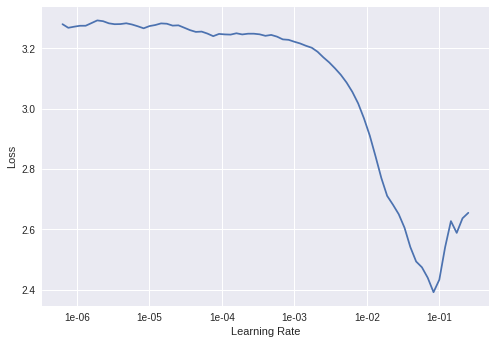

In [55]:
lr_find(learn)
learn.recorder.plot()

it looks like range between 2e-03 and 1e-02 is a good learning rate to use

In [0]:
learn.save('stage-0')

In [0]:
learn.load('stage-0')

Learner(data=DataBunch;
Train: LabelList
y: CategoryList (1116 items)
[5.643324375152588 5.6450934410095215 5.644386291503906 5.650381565093994 ... 5.976350784301758 5.978885650634766
 5.978885650634766 5.999184608459473]
Path: .
x: TabularList (1116 items)
[0 1 2 3 ... 1112 1113 1114 1115]
Path: /content/data;
Valid: LabelList
y: CategoryList (280 items)
[5.998688220977783 5.993961334228516 5.973300457000732 5.973809719085693 ... 6.05420446395874 6.048553466796875
 6.051618576049805 6.057720184326172]
Path: .
x: TabularList (280 items)
[0 1 2 3 ... 276 277 278 279]
Path: /content/data;
Test: None, model=TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 3)
    (1): Embedding(13, 6)
    (2): Embedding(6, 4)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=27, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, m

In [0]:
lr = 2e-03

Fit the NN

In [0]:
learn.fit_one_cycle(20, slice(lr))
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,exp_rmspe


TypeError: ignored

plotting training loss (blue) and val loss (green)

- should see loss increase a littel bit, then start to decrease
- if loss is always decreasing, means we can probably increase the lr 

saving model - stage 1

In [0]:
learn.save('stage-1') 

In [0]:
learn.load('stage-1')

divide lr by 5, experiment with different weight decay values



In [0]:
learn.fit_one_cycle(20, slice(lr/5), wd = 5e-03)
learn.recorder.plot_losses()

save model stage-2

In [0]:
#learn.save('lr5e-02_20epochs') #exp_rmspe = 0.035
learn.save('stage2') #exp_rmspe = 0.0178

## Results

After tuning the hyperparameters, the NN was able to achieve a validation Root Mean Square Percentage Error of 0.0178

# Tree-based Ensemble Classifiers

For ensemble classifiers, we mainly focus on Random Forests. GBM's are typically more prone to overfitting to noise, due to the nature of the boosting meta-algorithm.

By comparison, since Random Forests use bagging, they are typically more robust to variance in data.

Because financial data is typically noisy and unstructured, we can expect there to be noise in the data, which makes RF more attractive option to predict our data compared to GBMs

In the [Two Sigma Financial Modelling Challenge](http://blog.kaggle.com/2017/05/25/two-sigma-financial-modeling-challenge-winners-interview-2nd-place-nima-shahbazi-chahhou-mohamed/), the 2nd place solution did not use GMBs in the final model

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
valid_df

In [0]:
train_df_y = train_df['Log_Price']
valid_df_y = valid_df['Log_Price']

In [0]:
train_df_rf = train_df.drop(['Log_Price'], axis = 1)
valid_df_rf = valid_df.drop(['Log_Price'], axis = 1)

In [0]:
# defining function to evaluate exp_rmspe
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

In [0]:
m = RandomForestRegressor(n_estimators=100, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(train_df_rf, train_df_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
preds = m.predict(valid_df_rf)
exp_rmspe(preds, valid_df_y)

0.019217474767001155